# Water Pump Audio Anomaly Detection using MEL spectrograms + Audio Split (Homemade Data Augmentation) 

## Objective

The objective of this notebook is that of performing anomaly detection on water pump audio files. It uses a combination of MFCCs features and other statistical features of the audio files:

- Spectral Centroid
- Zero Crossing Rate
- Spectral Contrast
- Spectral rolloff
- Root Mean Square Energy

We've seen that splitting the audio files to increase the number of samples is not very effective.

## Feature Extraction:

We first extract MFCCs coefficients, and then we extract the other statistical features with the proper facilities provided by librosa. The features are separated and they are isolated in the whole process. The idea is to use two different autoencoders and then to concatenate the two latent space representations that we obtain. This may allow to get further insights on the structure of the instances and this may be helpful to better distinguish anomalies from nominal samples.

## Data Normalization:

We use MinMax scaler for normalizing all features. Using Standard Scaler is reasonable as well, but we figured it does not work as well as Min Max Scaler does.

## Model Design:

The initial idea was to use two different autoencoders to get a meaningful latent space reperesentation of the audio files. However, we abandoned the idea pretty quickly, as we did not see promising results. 

## Model Training:

In this case we opted for a Recurrrent Autoencoder, since we would have liked to capture time relations.

## Anomaly Detection:

Reconstruction errors from the autoencoder are used to identify anomalous audio segments. A threshold is specified to decide when an instance should be flagged as anomaly.

## Visualization and Evaluation:

Reconstruction error distributions are plotted to distinguish normal and anomalous data.


## Notes

Here we were able to push ourselves and integrate some ML to assess the overall performance of the AD pipeline, regardless of the autoencoder performance. 

We've tried several different strategies:

- Random Forest
- SVM
- Logistic Regression

As we can see the result are pretty bad. And this is where we started losing hope.

In [2]:
import os

dataset_base_path = "./water pump audio for anomaly detection/"
train_normal_path = os.path.join(dataset_base_path, "train-normal")
test_normal_path = os.path.join(dataset_base_path, "test-normal")
anomaly_path = os.path.join(dataset_base_path, "anomaly")

In [3]:
import librosa
import numpy as np

def load_audio_files(path, sr=22050, duration=10):
    audio_files = []
    for file in os.listdir(path):
        if file.endswith(".wav"):
            file_path = os.path.join(path, file)
            audio, _ = librosa.load(file_path, sr=sr, duration=duration)
            audio_files.append(audio)
    return np.array(audio_files)

In [4]:
train_normal_files = load_audio_files(train_normal_path)
test_normal_files = load_audio_files(test_normal_path)
anomaly_files = load_audio_files(anomaly_path)

In [5]:
def extract_mfcc_features(audio_files, sr=22050, n_mfcc=20):
    mfcc_features = []
    for audio in audio_files:
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        mfcc_features.append(mfcc)
    return np.array(mfcc_features)

In [6]:
train_mfcc_features = extract_mfcc_features(train_normal_files).transpose(0, 2, 1)
test_mfcc_features = extract_mfcc_features(test_normal_files).transpose(0, 2, 1)
anomaly_mfcc_features = extract_mfcc_features(anomaly_files).transpose(0, 2, 1)

In [7]:
print(train_mfcc_features.shape)
print(test_mfcc_features.shape)
print(anomaly_mfcc_features.shape)

(2241, 431, 20)
(400, 431, 20)
(456, 431, 20)


In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_mfcc_features = scaler.fit_transform(train_mfcc_features.reshape(-1, train_mfcc_features.shape[-1])).reshape(train_mfcc_features.shape)
test_mfcc_features = scaler.transform(test_mfcc_features.reshape(-1, test_mfcc_features.shape[-1])).reshape(test_mfcc_features.shape)
anomaly_mfcc_features = scaler.transform(anomaly_mfcc_features.reshape(-1, anomaly_mfcc_features.shape[-1])).reshape(anomaly_mfcc_features.shape)

In [9]:
def extract_features(audio_files):
  zrc = []
  rmse = []
  spectral_contrast = []
  spectral_centroid = []
  spectral_rolloff = []
  for audio in audio_files:
    zrc.append(librosa.feature.zero_crossing_rate(audio))
    rmse.append(librosa.feature.rms(y=audio))
    spectral_contrast.append(librosa.feature.spectral_contrast(y=audio))
    spectral_centroid.append(librosa.feature.spectral_centroid(y=audio))
    spectral_rolloff.append(librosa.feature.spectral_rolloff(y=audio))
  return np.array(zrc), np.array(rmse), np.array(spectral_contrast), np.array(spectral_centroid), np.array(spectral_rolloff)

In [ ]:
train_zrc, train_rmse, train_spectral_contrast, train_spectral_centroid, train_spectral_rolloff = extract_features(train_normal_files)
test_zrc, test_rmse, test_spectral_contrast, test_spectral_centroid, test_spectral_rolloff = extract_features(test_normal_files)
anomaly_zrc, anomaly_rmse, anomaly_spectral_contrast, anomaly_spectral_centroid, anomaly_spectral_rolloff = extract_features(anomaly_files)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_zrc = scaler.fit_transform(train_zrc.reshape(-1, train_zrc.shape[-1])).reshape(train_zrc.shape)
train_rmse = scaler.fit_transform(train_rmse.reshape(-1, train_rmse.shape[-1])).reshape(train_rmse.shape)
train_spectral_contrast = scaler.fit_transform(train_spectral_contrast.reshape(-1, train_spectral_contrast.shape[-1])).reshape(train_spectral_contrast.shape)
train_spectral_centroid = scaler.fit_transform(train_spectral_centroid.reshape(-1, train_spectral_centroid.shape[-1])).reshape(train_spectral_centroid.shape)
train_spectral_rolloff = scaler.fit_transform(train_spectral_rolloff.reshape(-1, train_spectral_rolloff.shape[-1])).reshape(train_spectral_rolloff.shape)

test_zrc = scaler.transform(test_zrc.reshape(-1, test_zrc.shape[-1])).reshape(test_zrc.shape)
test_rmse = scaler.transform(test_rmse.reshape(-1, test_rmse.shape[-1])).reshape(test_rmse.shape)
test_spectral_contrast = scaler.transform(test_spectral_contrast.reshape(-1, test_spectral_contrast.shape[-1])).reshape(test_spectral_contrast.shape)
test_spectral_centroid = scaler.transform(test_spectral_centroid.reshape(-1, test_spectral_centroid.shape[-1])).reshape(test_spectral_centroid.shape)
test_spectral_rolloff = scaler.transform(test_spectral_rolloff.reshape(-1, test_spectral_rolloff.shape[-1])).reshape(test_spectral_rolloff.shape)

anomaly_zrc = scaler.transform(anomaly_zrc.reshape(-1, anomaly_zrc.shape[-1])).reshape(anomaly_zrc.shape)
anomaly_rmse = scaler.transform(anomaly_rmse.reshape(-1, anomaly_rmse.shape[-1])).reshape(anomaly_rmse.shape)
anomaly_spectral_contrast = scaler.transform(anomaly_spectral_contrast.reshape(-1, anomaly_spectral_contrast.shape[-1])).reshape(anomaly_spectral_contrast.shape)
anomaly_spectral_centroid = scaler.transform(anomaly_spectral_centroid.reshape(-1, anomaly_spectral_centroid.shape[-1])).reshape(anomaly_spectral_centroid.shape)
anomaly_spectral_rolloff = scaler.transform(anomaly_spectral_rolloff.reshape(-1, anomaly_spectral_rolloff.shape[-1])).reshape(anomaly_spectral_rolloff.shape)



In [10]:
# mfcc autoencoder

import tensorflow as tf
from tensorflow.keras import layers, models

# Input dimensions
time_steps = 431  # Number of time frames
n_mfcc = 20    # Number of MFCC coefficients
latent_dim = 64   # Dimension of the latent space

# Encoder
encoder_inputs = tf.keras.Input(shape=(time_steps, n_mfcc))
encoded = layers.LSTM(128, return_sequences=True)(encoder_inputs)
encoded = layers.LSTM(latent_dim, return_sequences=False)(encoded)

# Decoder
decoded = layers.RepeatVector(time_steps)(encoded)
decoded = layers.LSTM(128, return_sequences=True)(decoded)
decoded = layers.LSTM(n_mfcc, return_sequences=True)(decoded)

# Autoencoder
autoencoder_mfcc = models.Model(encoder_inputs, decoded, name="Recurrent_Autoencoder")

# Encoder model (for extracting latent space representation)
latent_model_mfcc = models.Model(encoder_inputs, encoded, name="Encoder")

# Compile the autoencoder
autoencoder_mfcc.compile(optimizer='adam', loss='mse')

autoencoder_mfcc.summary()
latent_model_mfcc.summary()

Model: "Recurrent_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 431, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 431, 128)       │        76,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 431, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 431, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 431, 20)        │        11,920 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,432 (923.56 KB)

 Trainable params: 236,432 (923.56 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 431, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 431, 128)       │        76,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,696 (491.00 KB)

 Trainable params: 125,696 (491.00 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
autoencoder_mfcc.fit(
    train_mfcc_features,
    train_mfcc_features,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 533ms/step - loss: 0.0086 - val_loss: 0.0086
Epoch 2/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 467ms/step - loss: 0.0087 - val_loss: 0.0085
Epoch 3/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 470ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 4/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 465ms/step - loss: 0.0084 - val_loss: 0.0084
Epoch 5/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 27s 476ms/step - loss: 0.0085 - val_loss: 0.0083


In [13]:
#reconstructed_train = autoencoder.predict(train_mel_specs_reshaped)
reconstructed_test = autoencoder_mfcc.predict(test_mfcc_features)
reconstructed_anomaly = autoencoder_mfcc.predict(anomaly_mfcc_features)

# Calculate Mean Squared Error (MSE) for reconstruction loss
#train_loss = np.mean(np.square(train_mel_specs_reshaped - reconstructed_train), axis=(1, 2, 3))
test_loss = np.mean(np.square(test_mfcc_features - reconstructed_test), axis=(1, 2))
anomaly_loss = np.mean(np.square(anomaly_mfcc_features - reconstructed_anomaly), axis=(1, 2))

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step


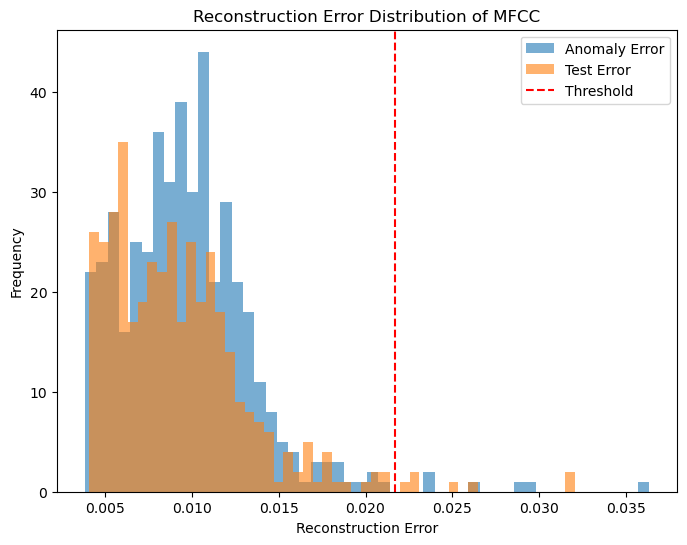

In [14]:
import matplotlib.pyplot as plt

# Plot histogram of reconstruction errors
plt.figure(figsize=(8, 6))
plt.hist(anomaly_loss, bins=50, alpha=0.6, label='Anomaly Error')
plt.hist(test_loss, bins=50, alpha=0.6, label='Test Error')
plt.axvline(np.mean(test_loss) + 3 * np.std(test_loss), color='r', linestyle='--', label='Threshold')
plt.title("Reconstruction Error Distribution of MFCC")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [15]:
train_mfcc_latent = latent_model_mfcc.predict(train_mfcc_features)
test_mfcc_latent = latent_model_mfcc.predict(test_mfcc_features)
anomaly_mfcc_latent = latent_model_mfcc.predict(anomaly_mfcc_features)

print(train_mfcc_latent.shape)
print(test_mfcc_latent.shape)
print(anomaly_mfcc_latent.shape)

71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
(2241, 64)
(400, 64)
(456, 64)


In [16]:
# Combine data and create labels (normal: 0, anomaly: 1)
index_train = np.random.choice(train_mfcc_latent.shape[0], 400, replace=False)
index_test = np.random.choice(test_mfcc_latent.shape[0], 200, replace=False)
index_anomaly = np.random.choice(anomaly_mfcc_latent.shape[0], 200, replace=False)

X_train = np.concatenate([train_mfcc_latent[index_train], test_mfcc_latent[index_test], anomaly_mfcc_latent[index_anomaly]], axis=0)
y_train = np.concatenate([np.zeros(400 + 200), np.ones(200)], axis=0)

In [17]:
# Selezione degli indici complementari per test e anomaly
complementary_index_train = np.setdiff1d(np.arange(train_mfcc_latent.shape[0]), index_train)
complementary_index_test = np.setdiff1d(np.arange(test_mfcc_latent.shape[0]), index_test)
complementary_index_anomaly = np.setdiff1d(np.arange(anomaly_mfcc_latent.shape[0]), index_anomaly)

# Creazione di X_test
X_test = np.concatenate([train_mfcc_latent[complementary_index_train], test_mfcc_latent[complementary_index_test], anomaly_mfcc_latent[complementary_index_anomaly]], axis=0)

# Creazione di y_test (0 per normal, 1 per anomaly)
y_test = np.concatenate([np.zeros(len(complementary_index_train)), np.zeros(len(complementary_index_test)), np.ones(len(complementary_index_anomaly))], axis=0)

# Output della dimensione dei dati per verifica
print(f"Dimensioni X_test: {X_test.shape}")
print(f"Dimensioni y_test: {y_test.shape}")


Dimensioni X_test: (2297, 64)
Dimensioni y_test: (2297,)


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score


pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))  # Step 2: Random Forest
])

# Define hyperparameter grid for Random Forest
param_grid = {
    'classifier__n_estimators': [50, 100, 200],  # Number of trees
    'classifier__max_depth': [None, 10, 20, 30],  # Tree depth
    'classifier__min_samples_split': [2, 5, 10],  # Min samples to split a node
    'classifier__min_samples_leaf': [1, 2, 4],  # Min samples in a leaf node
    'classifier__bootstrap': [True, False]  # Whether to bootstrap samples
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5,  # 5-fold cross-validation
    scoring='roc_auc',  # Use ROC-AUC as the evaluation metric
    n_jobs=-1,  # Use all available CPU cores
    verbose=2
)

# Fit GridSearchCV to training data
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation ROC-AUC Score:", grid_search.best_score_)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.2s
[CV] END classifier__bootstrap=True, classifie

In [19]:
# Best model from GridSearchCV
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]  # Probability for the positive class

# Evaluate performance
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate ROC-AUC
auc_score = roc_auc_score(y_test, y_prob)
print(f"Test ROC-AUC Score: {auc_score:.2f}")


Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94      2041
         1.0       0.53      0.25      0.34       256

    accuracy                           0.89      2297
   macro avg       0.72      0.61      0.64      2297
weighted avg       0.87      0.89      0.87      2297

Test ROC-AUC Score: 0.78


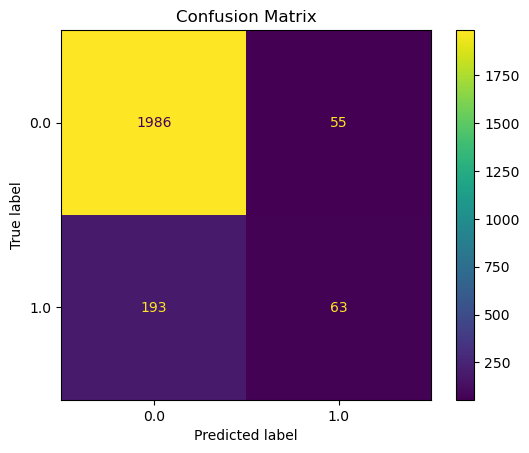

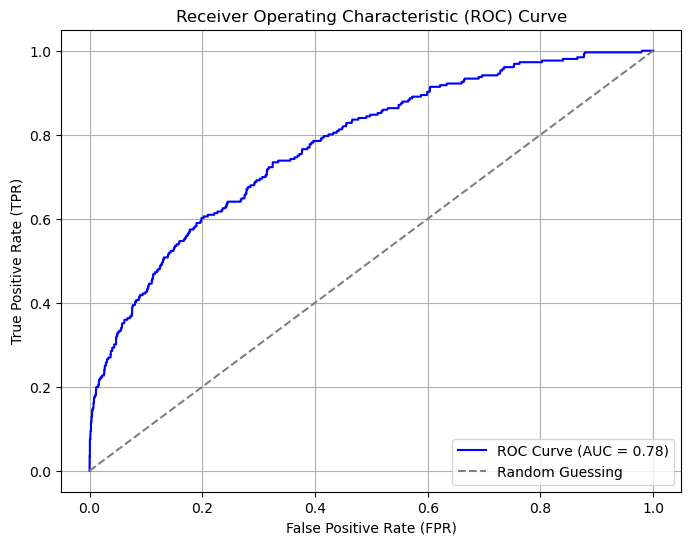


Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94      2041
         1.0       0.53      0.25      0.34       256

    accuracy                           0.89      2297
   macro avg       0.72      0.61      0.64      2297
weighted avg       0.87      0.89      0.87      2297


ROC-AUC Score: 0.78


In [20]:
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score, classification_report

# Confusion matrix
# Usa y_pred (classi predette) per creare la matrice di confusione
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
# Usa y_prob (probabilità predette per la classe positiva) per generare la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)  # Calcola l'Area Under the Curve (AUC)

# Plot della curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guessing")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Classification Report
# Usa y_pred per generare un rapporto di classificazione
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
# Usa y_prob per calcolare il ROC-AUC score
roc_auc_score_value = roc_auc_score(y_test, y_prob)
print(f"\nROC-AUC Score: {roc_auc_score_value:.2f}")


In [ ]:
from sklearn.svm import SVC

# Train an SVM classifier
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)

# Predict and evaluate
y_pred = svm.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, svm.predict_proba(X_test)[:, 1])
print("ROC-AUC Score:", roc_auc)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      1.00      0.93       542
         1.0       0.00      0.00      0.00        78

    accuracy                           0.87       620
   macro avg       0.44      0.50      0.47       620
weighted avg       0.76      0.87      0.82       620

Confusion Matrix:
 [[542   0]
 [ 78   0]]
ROC-AUC Score: 0.8158293121392751


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest
clf = IsolationForest(n_estimators=100, contamination=0.15, random_state=42)
clf.fit(X_train)


IsolationForest(contamination=0.15, random_state=42)

In [ ]:
# Predict anomaly scores for test data
anomaly_scores = clf.decision_function(X_test)  # Higher is more normal
predictions = clf.predict(X_test)  # -1 for anomaly, 1 for normal

# Convert predictions to binary classification (0: normal, 1: anomaly)
binary_predictions = [1 if x == -1 else 0 for x in predictions]



In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

# Classification report
print(classification_report(y_test, binary_predictions, target_names=["Normal", "Anomaly"]))

# AUC-ROC score
auc_score = roc_auc_score(y_test, anomaly_scores)
print(f"AUC-ROC Score: {auc_score:.2f}")


              precision    recall  f1-score   support

      Normal       0.87      0.85      0.86       542
     Anomaly       0.12      0.14      0.13        78

    accuracy                           0.76       620
   macro avg       0.50      0.50      0.50       620
weighted avg       0.78      0.76      0.77       620

AUC-ROC Score: 0.43


In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

X_train_normal = X_train[y_train == 0]
# Create and fit the One-Class SVM
oc_svm = OneClassSVM(kernel="rbf", nu=0.05, gamma="scale")
oc_svm.fit(X_train_normal)


OneClassSVM(nu=0.05)

In [ ]:
# Predict on the test set
y_pred = oc_svm.predict(X_test)
binary_predictions = (y_pred == -1).astype(int)  # Convert -1 to anomaly (1)

# Get anomaly scores (distance from the decision boundary)
anomaly_scores = oc_svm.decision_function(X_test)


In [ ]:
# Classification report
print(classification_report(y_test, binary_predictions, target_names=["Normal", "Anomaly"]))

# AUC-ROC Score
auc_score = roc_auc_score(y_test, anomaly_scores)
print(f"AUC-ROC Score: {auc_score:.2f}")


              precision    recall  f1-score   support

      Normal       0.88      0.95      0.91       542
     Anomaly       0.16      0.06      0.09        78

    accuracy                           0.84       620
   macro avg       0.52      0.51      0.50       620
weighted avg       0.79      0.84      0.81       620

AUC-ROC Score: 0.43


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# Train Logistic Regression
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]  # Probability of being anomaly

# Evaluate
print(classification_report(y_test, y_pred))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_prob):.2f}")

              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94       542
         1.0       0.61      0.14      0.23        78

    accuracy                           0.88       620
   macro avg       0.75      0.56      0.58       620
weighted avg       0.85      0.88      0.85       620

AUC-ROC Score: 0.73


In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Load audio file
audio_path = 'audio_file.wav'
y, sr = librosa.load(audio_path, sr=None)  # Load with the original sample rate

# Compute the Short-Time Fourier Transform (STFT)
n_fft = 2048  # Length of FFT window
hop_length = 512  # Number of samples between successive frames
stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)

# Convert the complex values to magnitude
spectrogram = np.abs(stft)

# Visualize the Spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),
                         sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()